Shape of df1: (114000, 21)
First 5 rows of df1:
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Be

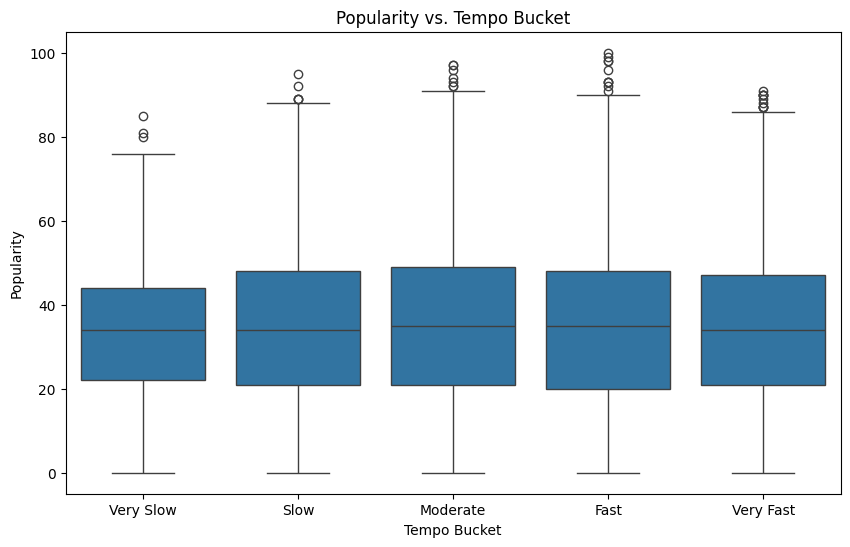

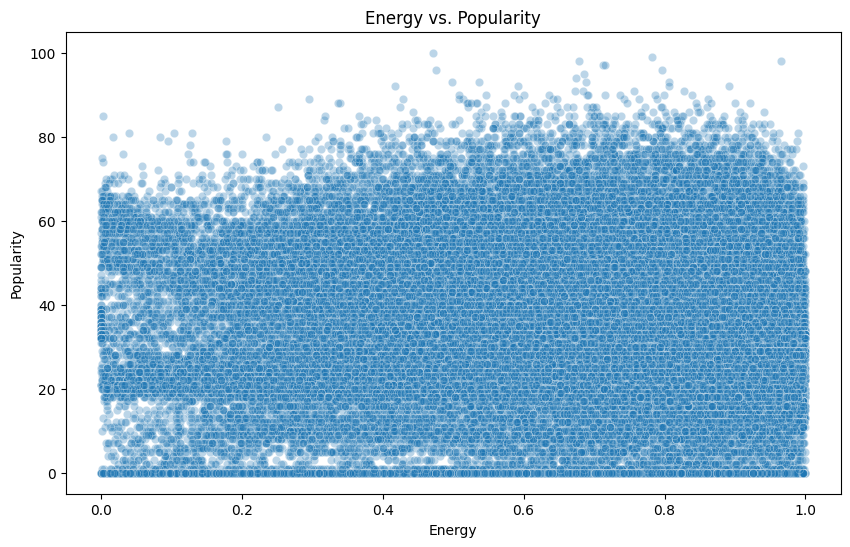

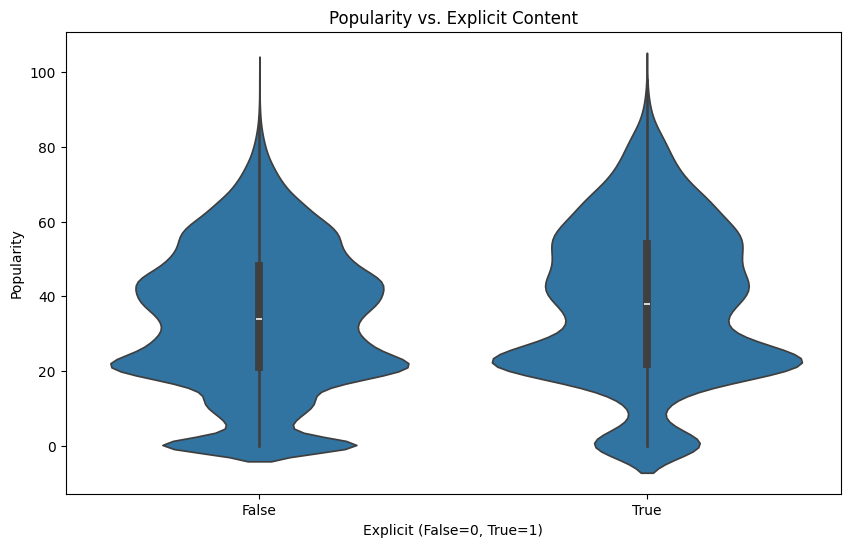

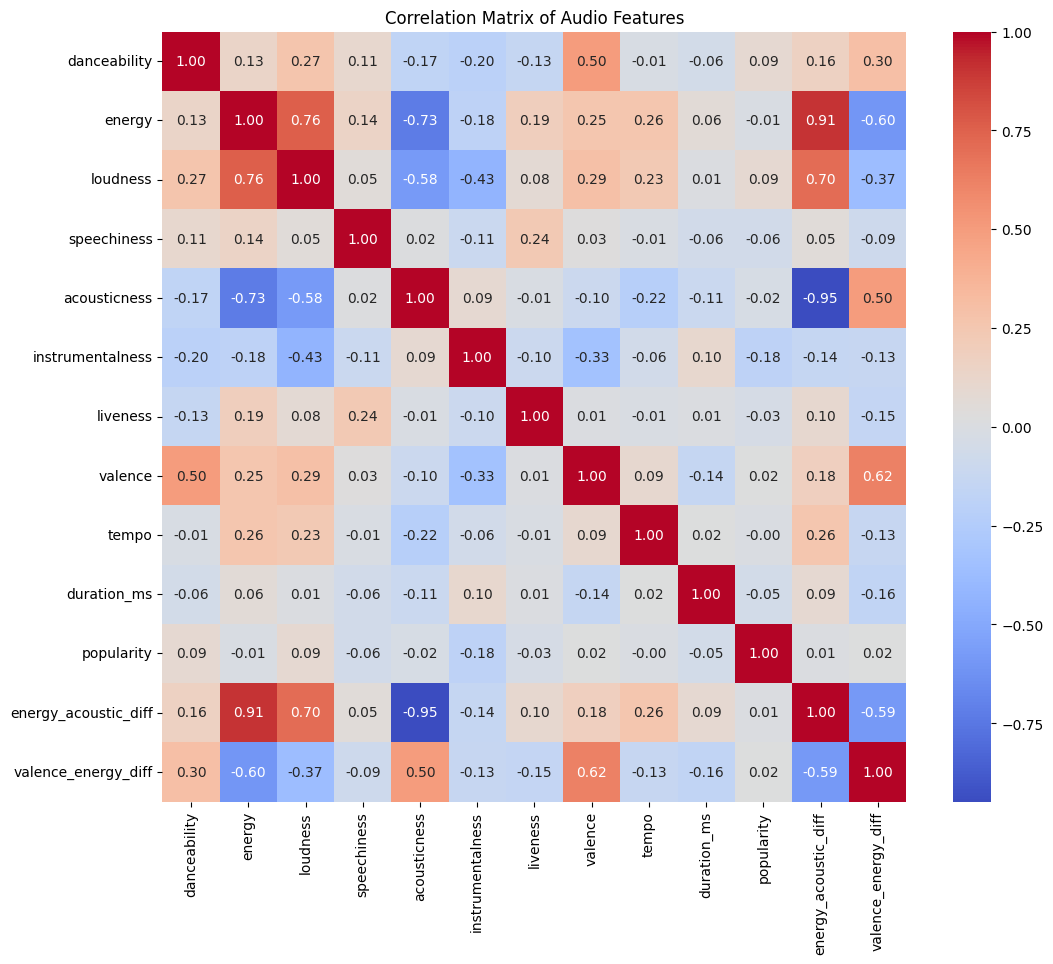

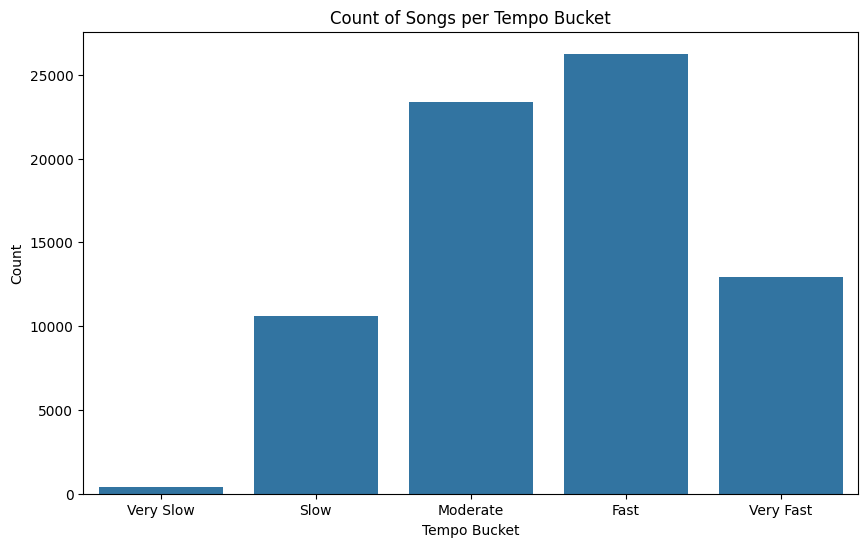

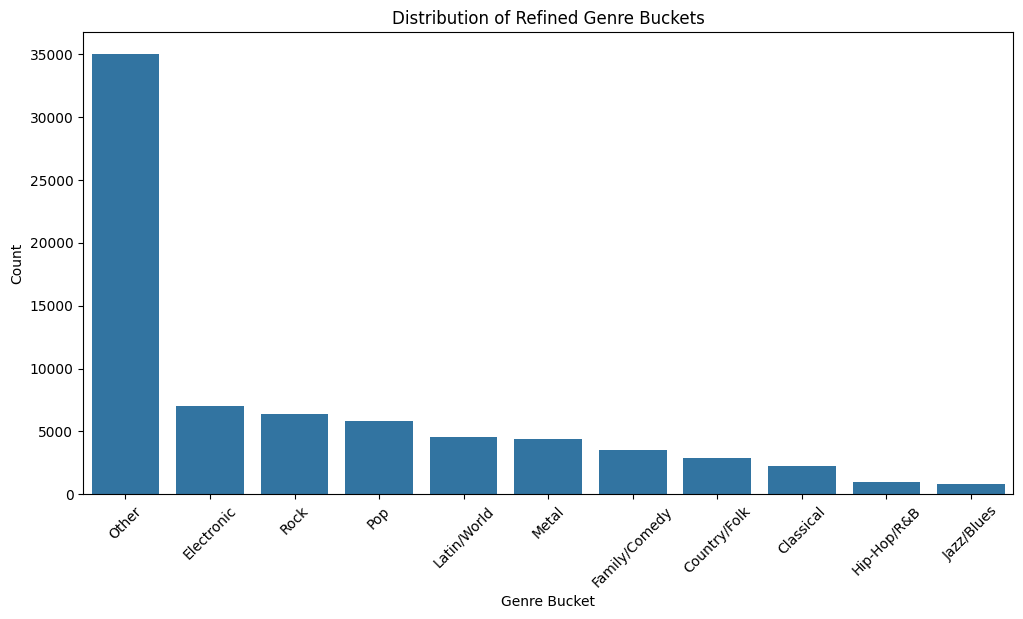

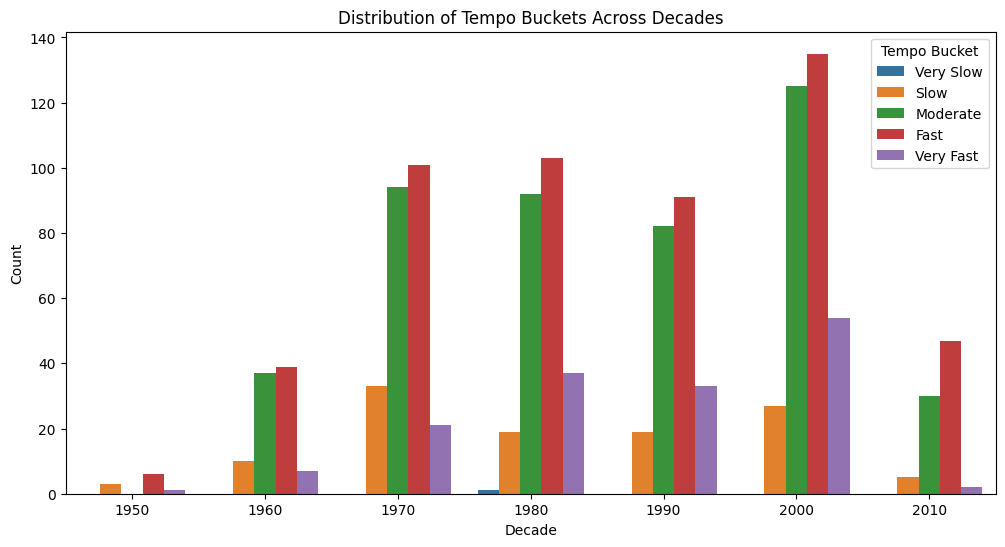

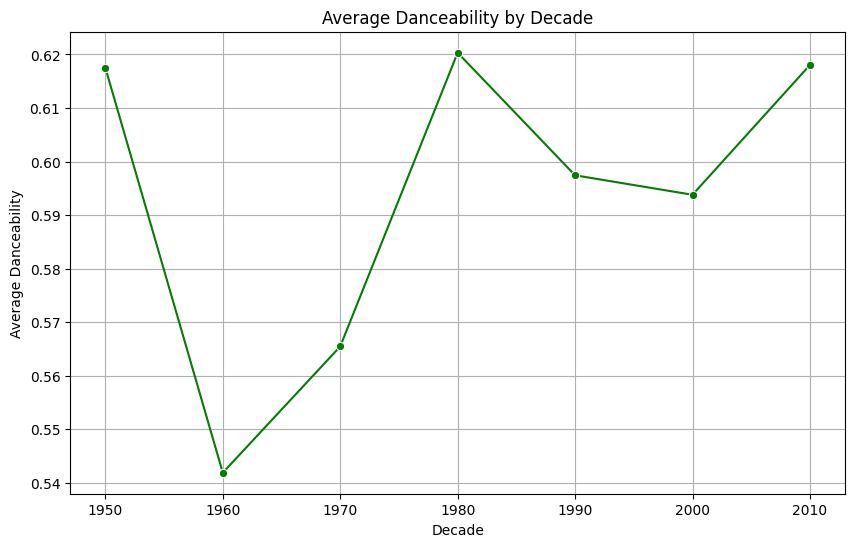

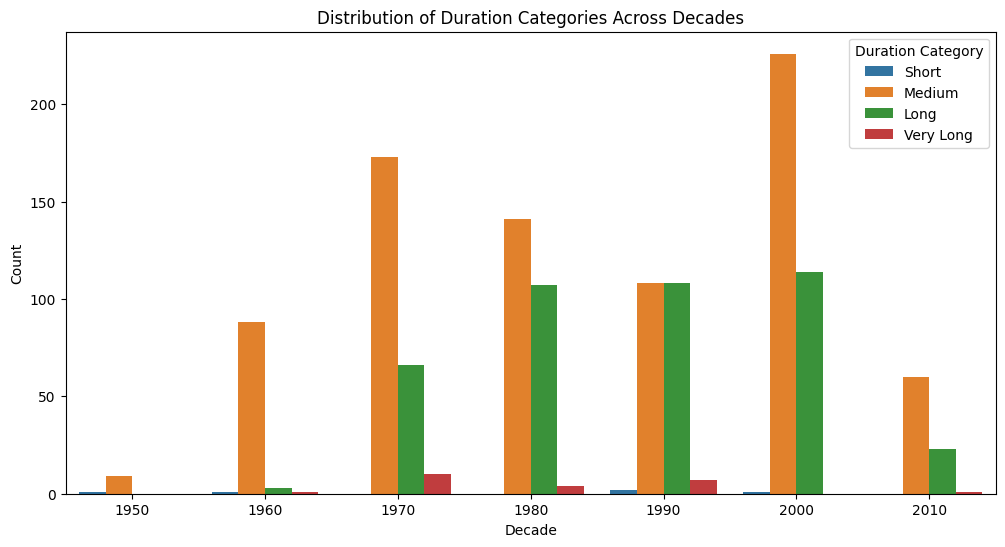

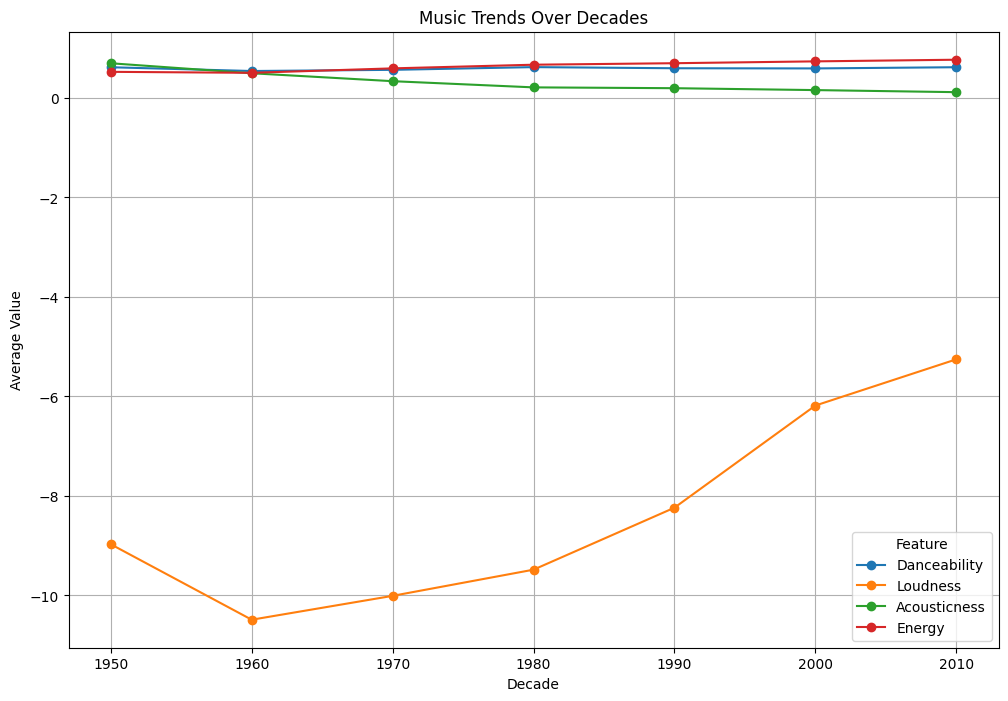

EDA for both datasets completed.
 - df1 (Random Dataset) is now processed for training the recommendation models.
 - df2 (Top 10k Dataset) is used for analyzing trends in music across decades.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler

# ============================
# Part 1: EDA for Random Dataset (df1)
# ============================

# --- Load the Training Dataset ---
df1 = pd.read_csv('/content/train.csv')

# --- Initial Data Inspection ---
print("Shape of df1:", df1.shape)
print("First 5 rows of df1:")
print(df1.head())
print("Info for df1:")
print(df1.info())

def map_genre_to_bucket(genre):
    # Convert to lowercase for case-insensitive matching
    g = str(genre).lower()

    # Pop
    if re.search(r'pop', g):
        return 'Pop'

    # Rock (includes alternative, indie, emo, punk, etc.)
    elif re.search(r'rock|guitar|punk|grunge|emo', g):
        return 'Rock'

    # Hip-Hop/R&B
    elif re.search(r'hip[\s-]?hop|r[-\s]?n[-\s]?b|rap', g):
        return 'Hip-Hop/R&B'

    # Electronic (includes EDM, techno, trance, house, dubstep, etc.)
    elif re.search(r'electronic|edm|techno|trance|house|dubstep|deep[-\s]?house|progressive[-\s]?house|idm', g):
        return 'Electronic'

    # Jazz/Blues
    elif re.search(r'jazz|blues', g):
        return 'Jazz/Blues'

    # Classical/Opera/New Age
    elif re.search(r'classical|opera|new[-\s]?age', g):
        return 'Classical'

    # Metal (includes black metal, death metal, metalcore, etc.)
    elif re.search(r'metal|grindcore', g):
        return 'Metal'

    # Country/Folk/Bluegrass
    elif re.search(r'country|bluegrass|honky[-\s]?tonk|folk', g):
        return 'Country/Folk'

    # Latin/World (includes salsa, samba, reggaeton, latino, forro, mpb, etc.)
    elif re.search(r'latin|salsa|samba|reggaeton|latino|brazil|mpb|tango', g):
        return 'Latin/World'

    # Other special categories (children, comedy, disney, anime, etc.)
    elif re.search(r'children|comedy|disney|anime', g):
        return 'Family/Comedy'

    # If none of the above match, return 'Other'
    else:
        return 'Other'

# --- Data Cleaning ---
# Define key audio features
relevant_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'popularity']


# Drop rows with missing values in key columns
df1.dropna(subset=relevant_cols, inplace=True)
# Remove duplicates
df1.drop_duplicates(inplace=True)
# Remove rows with non-positive duration
df1 = df1[df1['duration_ms'] > 0]

df1 = df1.drop_duplicates(subset=['track_name'], keep='first')


# --- Feature Engineering ---
# Create tempo buckets
tempo_bins = [-np.inf, 60, 90, 120, 150, np.inf]
tempo_labels = ['Very Slow', 'Slow', 'Moderate', 'Fast', 'Very Fast']
df1['tempo_bucket'] = pd.cut(df1['tempo'], bins=tempo_bins, labels=tempo_labels)

# Create duration categories based on minutes
df1['duration_min'] = df1['duration_ms'] / 60000.0
duration_bins = [-np.inf, 2, 4, 6, np.inf]
duration_labels = ['Short', 'Medium', 'Long', 'Very Long']
df1['duration_cat'] = pd.cut(df1['duration_min'], bins=duration_bins, labels=duration_labels)

df1['energy_acoustic_diff'] = df1['energy'] - df1['acousticness']
df1['valence_energy_diff'] = df1['valence'] - df1['energy']


df1['genre_bucket'] = df1['track_genre'].apply(map_genre_to_bucket)

# Let's see how many tracks fall into each bucket:
genre_bucket_counts = df1['genre_bucket'].value_counts()
print("Genre bucket counts:")
print(genre_bucket_counts)

# --- Exploratory Visualizations for df1 ---

# 1. Tempo Bucket vs. Popularity (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='tempo_bucket', y='popularity', data=df1, order=tempo_labels)
plt.title("Popularity vs. Tempo Bucket")
plt.xlabel("Tempo Bucket")
plt.ylabel("Popularity")
plt.show()


# 3. Energy vs. Popularity (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='energy', y='popularity', data=df1, alpha=0.3)
plt.title("Energy vs. Popularity")
plt.xlabel("Energy")
plt.ylabel("Popularity")
plt.show()

# 4. Explicit Content vs. Popularity (Violin Plot), if column exists
if 'explicit' in df1.columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='explicit', y='popularity', data=df1)
    plt.title("Popularity vs. Explicit Content")
    plt.xlabel("Explicit (False=0, True=1)")
    plt.ylabel("Popularity")
    plt.show()

# 5. Correlation Heatmap for Numeric Audio Features
numeric_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'popularity',
                'energy_acoustic_diff', 'valence_energy_diff']

plt.figure(figsize=(12, 10))
corr_matrix = df1[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Audio Features")
plt.show()

features = df1[numeric_cols].values

# 6. Count of Songs per Tempo Bucket
plt.figure(figsize=(10, 6))
sns.countplot(x='tempo_bucket', data=df1, order=tempo_labels)
plt.title("Count of Songs per Tempo Bucket")
plt.xlabel("Tempo Bucket")
plt.ylabel("Count")
plt.show()

# Visualize the distribution of the broader genre buckets
plt.figure(figsize=(12, 6))
sns.countplot(data=df1, x='genre_bucket', order=genre_bucket_counts.index)
plt.title("Distribution of Refined Genre Buckets")
plt.xlabel("Genre Bucket")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# ============================
# Part 2: EDA for Top 10k Dataset (df2) - Trend Analysis Across Decades
# ============================

# --- Load the Top 10k Dataset ---
df2 = pd.read_csv('/content/top_10000_1950-now (1).csv')

# --- Data Cleaning for df2 ---
audio_cols = ['Danceability', 'Energy', 'Loudness', 'Speechiness',
              'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
              'Tempo', 'Track Duration (ms)', 'Popularity']
df2.dropna(subset=audio_cols, inplace=True)
df2.drop_duplicates(inplace=True)
df2 = df2[df2['Track Duration (ms)'] > 0]

# --- Feature Scaling for df1 only ---

scaler = StandardScaler()
df1[numeric_cols] = scaler.fit_transform(df1[numeric_cols].values)

# --- Feature Engineering on df2 for Trend Analysis ---
# Convert 'Album Release Date' to datetime and extract year
df2['Album Release Date'] = pd.to_datetime(df2['Album Release Date'], errors='coerce')
df2 = df2.dropna(subset=['Album Release Date'])
df2['year'] = df2['Album Release Date'].dt.year

# Create a decade column
df2['decade'] = (df2['year'] // 10) * 10

# Create engineered features: tempo buckets and duration categories
df2['tempo_bucket'] = pd.cut(df2['Tempo'], bins=tempo_bins, labels=tempo_labels)
df2['duration_min'] = df2['Track Duration (ms)'] / 60000.0
df2['duration_cat'] = pd.cut(df2['duration_min'], bins=duration_bins, labels=duration_labels)

# --- Exploratory Visualizations for df2 (Music Trends Across Decades) ---


# 3. Distribution of Tempo Buckets Across Decades
plt.figure(figsize=(12, 6))
sns.countplot(data=df2, x='decade', hue='tempo_bucket', order=sorted(df2['decade'].unique()))
plt.title('Distribution of Tempo Buckets Across Decades')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Tempo Bucket')
plt.show()

# 4. Trend in Danceability Over the Decades
dance_trend = df2.groupby('decade')['Danceability'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='decade', y='Danceability', data=dance_trend, marker='o', color='green')
plt.title('Average Danceability by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Danceability')
plt.grid(True)
plt.show()

# 5. Distribution of Duration Categories Across Decades
plt.figure(figsize=(12, 6))
sns.countplot(data=df2, x='decade', hue='duration_cat', order=sorted(df2['decade'].unique()))
plt.title('Distribution of Duration Categories Across Decades')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Duration Category')
plt.show()

trend_cols = ['Danceability', 'Loudness', 'Acousticness', 'Energy']
trend_df = df2.groupby('decade')[trend_cols].mean().reset_index()

plt.figure(figsize=(12, 8))
for col in trend_cols:
    plt.plot(trend_df['decade'], trend_df[col], marker='o', label=col)

plt.title("Music Trends Over Decades")
plt.xlabel("Decade")
plt.ylabel("Average Value")
plt.legend(title="Feature")
plt.grid(True)
plt.show()

# --- Summary ---
print("EDA for both datasets completed.")
print(" - df1 (Random Dataset) is now processed for training the recommendation models.")
print(" - df2 (Top 10k Dataset) is used for analyzing trends in music across decades.")


df1.to_csv('/content/train_processed.csv',index=False)


Summary statistics of scaled numeric columns:
         popularity   duration_ms  danceability        energy      loudness  \
count  7.360800e+04  7.360800e+04  7.360800e+04  7.360800e+04  7.360800e+04   
mean   1.714384e-16 -1.698939e-17 -3.011756e-17  5.869063e-17 -5.560165e-17   
std    1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00   
min   -1.791584e+00 -1.878595e+00 -3.129684e+00 -2.462259e+00 -7.693396e+00   
25%   -6.974547e-01 -4.891113e-01 -6.368421e-01 -6.956170e-01 -3.503484e-01   
50%   -2.013683e-02 -1.365313e-01  8.019998e-02  1.664425e-01  2.515623e-01   
75%    7.092824e-01  3.064502e-01  7.356213e-01  8.584095e-01  6.508779e-01   
max    3.418554e+00  4.206121e+01  2.388179e+00  1.403478e+00  2.469346e+00   

        speechiness  acousticness  instrumentalness      liveness  \
count  7.360800e+04  7.360800e+04      7.360800e+04  7.360800e+04   
mean   7.876900e-17  6.177961e-17     -2.471184e-17 -2.409405e-16   
std    1.000007e+00  1.000007e+00  

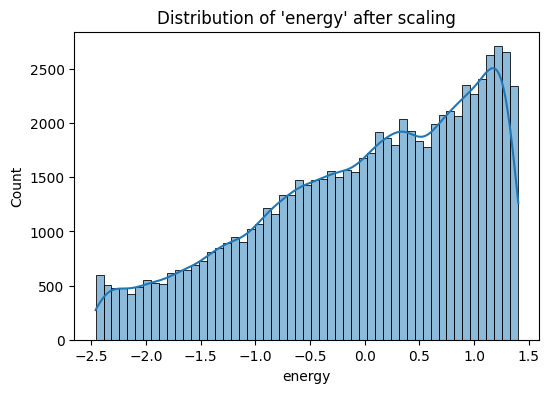

In [2]:
#df is the DataFrame after feature engineering and scaling.

import pandas as pd

df = pd.read_csv('/content/train_processed.csv')
# 1. Verify summary statistics for numeric columns
numeric_cols = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'energy_acoustic_diff', 'valence_energy_diff'
    # ... add any other numeric features you've scaled
]

print("Summary statistics of scaled numeric columns:")
print(df[numeric_cols].describe())

# 2. Check for null values
null_counts = df.isnull().sum()
print("\nNull values in each column:")
print(null_counts[null_counts > 0])  # Only show columns with non-zero null counts

# 3. Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# 4.Quick Visual Check of a Single Feature Distribution to verify the data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df['energy'], kde=True)
plt.title("Distribution of 'energy' after scaling")
plt.show()


In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model


# ----------------------------------------------------------------------
# The dataset has been loaded and preprocessed. It has the following features:
#  - Numeric audio features (e.g., 'danceability', 'energy', etc.)
#  - Engineered features: 'tempo_bucket' and 'duration_cat'
#  - Other columns like 'track_name', 'artist' or 'artist_name'
# Here we define the numeric feature columns and extract the feature matrix.
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'popularity',
                'energy_acoustic_diff', 'valence_energy_diff']
# df_train should be preprocessed and loaded:
df_train = pd.read_csv('/content/train_processed.csv')
# (plus any cleaning, scaling, and feature engineering)

features = df_train[feature_cols].values  # Numeric feature matrix from df_train


# ----------------------------------------------------------------------
# ---------- Cosine Similarity-based Content Filtering ----------
def recommend_cosine(seed_index, feature_matrix, k=10):
    seed_vector = feature_matrix[seed_index]
    sims = cosine_similarity(seed_vector.reshape(1, -1), feature_matrix).flatten()
    similar_indices = sims.argsort()[::-1]
    similar_indices = similar_indices[similar_indices != seed_index]
    return similar_indices[:k]

# Example recommendation for seed index 0 using cosine similarity
seed_idx = 5  # Adjust the index as needed
cosine_recs = recommend_cosine(seed_idx, features, k=5)
print("Cosine-similarity recommendations (indices):", cosine_recs)
if 'track_name' in df_train.columns:
    print("Recommended songs (Cosine):", df_train.iloc[cosine_recs]['track_name'].tolist())

# ----------------------------------------------------------------------
# ---------- KNN-based Content Filtering ----------
nn_model = NearestNeighbors(n_neighbors=11, metric='euclidean')
nn_model.fit(features)
def recommend_knn(seed_index, model, k=10):
    distances, indices = model.kneighbors(features[seed_index].reshape(1, -1), n_neighbors=k+1)
    rec_indices = [idx for idx in indices.flatten() if idx != seed_index]
    return rec_indices[:k]

knn_recs = recommend_knn(seed_idx, nn_model, k=5)
print("KNN recommendations (indices):", knn_recs)
if 'track_name' in df_train.columns:
    print("Recommended songs (KNN):", df_train.iloc[knn_recs]['track_name'].tolist())

# ----------------------------------------------------------------------
# ---------- Autoencoder-based Deep Learning Model ----------
input_dim = features.shape[1]
encoding_dim = 16  # Dimension of the latent feature space

# Build the autoencoder architecture
inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(inputs)
encoded = layers.Dense(encoding_dim, activation='relu')(x)
x = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(x)
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder (unsupervised training with a validation split)
autoencoder.fit(features, features, epochs=20, batch_size=256, validation_split=0.1, verbose=0)

# Extract the encoder model to get latent features
encoder_model = Model(inputs, encoded)
latent_features = encoder_model.predict(features)
print("Latent feature shape:", latent_features.shape)

def recommend_autoencoder(seed_index, latent_matrix, k=10):
    seed_vec = latent_matrix[seed_index]
    sims = cosine_similarity(seed_vec.reshape(1, -1), latent_matrix).flatten()
    sim_indices = sims.argsort()[::-1]
    sim_indices = sim_indices[sim_indices != seed_index]
    return sim_indices[:k]

ae_recs = recommend_autoencoder(seed_idx, latent_features, k=5)
print("Autoencoder recommendations (indices):", ae_recs)
if 'track_name' in df_train.columns:
    print("Recommended songs (Autoencoder):", df_train.iloc[ae_recs]['track_name'].tolist())

# ----------------------------------------------------------------------
# ---------- K-Means Clustering-based Recommendation ----------
# Combine numeric features with one-hot encoded engineered features.
# We assume df_train already contains engineered columns: 'tempo_bucket' and 'duration_cat'
eng_features = pd.get_dummies(df_train[['tempo_bucket', 'duration_cat']], drop_first=True)

genre_dummies = pd.get_dummies(df_train['genre_bucket'], prefix='genre')


features_cluster = np.hstack([features, eng_features.values,genre_dummies.values])


# (For demonstration, let's just print the shape of the resulting one-hot encoding.)
print("One-hot encoded genre bucket shape:", genre_dummies.shape)

# Train a K-Means clustering model (e.g., with 10 clusters)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_cluster)
df_train['cluster'] = clusters  # Save the cluster assignments in the training DataFrame

def recommend_kmeans(seed_index, features_cluster, clusters, k=10):
    # Get the cluster of the seed track
    seed_cluster = clusters[seed_index]
    # Find indices in the same cluster (excluding the seed)
    cluster_indices = np.where(clusters == seed_cluster)[0]
    cluster_indices = cluster_indices[cluster_indices != seed_index]
    # Within the cluster, rank tracks by cosine similarity using the original features
    seed_vector = features[seed_index]
    sims = cosine_similarity(seed_vector.reshape(1, -1), features[cluster_indices]).flatten()
    sorted_within_cluster = cluster_indices[sims.argsort()[::-1]]
    return sorted_within_cluster[:k]

kmeans_recs = recommend_kmeans(seed_idx, features_cluster, clusters, k=5)
print("K-Means recommendations (indices):", kmeans_recs)
if 'track_name' in df_train.columns:
    print("Recommended songs (K-Means):", df_train.iloc[kmeans_recs]['track_name'].tolist())

# ----------------------------------------------------------------------
# ---------- Evaluation Metrics ----------
def precision_at_k(recommended_indices, relevant_set, k):
    if k == 0:
        return 0.0
    hits = sum(1 for idx in recommended_indices[:k] if idx in relevant_set)
    return hits / k

def recall_at_k(recommended_indices, relevant_set, k):
    if len(relevant_set) == 0:
        return 0.0
    hits = sum(1 for idx in recommended_indices[:k] if idx in relevant_set)
    return hits / len(relevant_set)

def average_precision(recommended_indices, relevant_set, k):
    """Compute average precision at k for a single query."""
    hits = 0
    sum_precisions = 0.0
    for i in range(1, k+1):
        if recommended_indices[i-1] in relevant_set:
            hits += 1
            sum_precisions += hits / i
    # If no relevant items in the recommendations, return 0
    return sum_precisions / len(relevant_set) if relevant_set else 0.0


def hit_rate(recommended_indices, relevant_set, k):
    """Returns 1 if any of the top-k recommendations is relevant, else 0."""
    return 1.0 if any(idx in relevant_set for idx in recommended_indices[:k]) else 0.0


if 'genre_bucket' in df_train.columns:
    seed_genre_bucket = df_train.iloc[seed_idx]['genre_bucket']
    relevant_set = set(df_train[df_train['genre_bucket'] == seed_genre_bucket].index)
    relevant_set.discard(seed_idx)
else:
    relevant_set = set()


models_recs = {
    "Cosine": cosine_recs,
    "KNN": knn_recs,
    "Autoencoder": ae_recs,
    "K-Means": kmeans_recs
}

def diversity(recommended_indices, df):
        rec_genres = df.iloc[recommended_indices]['track_genre']
        return len(set(rec_genres)) / len(recommended_indices) if len(recommended_indices) >0 else 0

def novelty(recommended_indices, df):
    if 'popularity' in df.columns:
        return df.iloc[recommended_indices]['popularity'].mean()
    return None

def feature_similarity(seed_index, recommended_indices, feature_matrix):
    seed_vec = feature_matrix[seed_index]
    dists = [np.linalg.norm(seed_vec - feature_matrix[idx]) for idx in recommended_indices]
    return np.mean(dists) if dists else None

k = 5
for model_name, rec_indices in models_recs.items():
    prec = precision_at_k(rec_indices, relevant_set, k)
    rec = recall_at_k(rec_indices, relevant_set, k)
    ap = average_precision(rec_indices, relevant_set, k)
    hit = hit_rate(rec_indices, relevant_set, k)

    # The previously defined diversity, novelty, and feature similarity functions:
    div = diversity(rec_indices, df_train)
    nov = novelty(rec_indices, df_train)
    fsim = feature_similarity(seed_idx, rec_indices, features)

    # Format output, using "N/A" if any metric is None.
    prec_str = f"{prec:.2f}" if prec is not None else "N/A"
    hit_str = f"{hit:.2f}" if hit is not None else "N/A"
    div_str = f"{div:.2f}" if div is not None else "N/A"
    nov_str = f"{nov:.2f}" if nov is not None else "N/A"
    fsim_str = f"{fsim:.2f}" if fsim is not None else "N/A"

    print(f"{model_name} -> Precision@5: {prec_str}, "
          f"Hit Rate: {hit_str}, Diversity: {div_str}, "
          f"Novelty (avg popularity): {nov_str}, Feature similarity (distance): {fsim_str}")

# ----------------------------------------------------------------------
# --- Notes on Splitting ---
# For these unsupervised methods (cosine similarity, KNN, clustering), a train/test split is not strictly required
# because there is no target label. For the autoencoder model, a validation split is used during training.
# In systems with user feedback, a proper train/test or cross-validation approach is recommended.


Cosine-similarity recommendations (indices): [12769 20344 66727   435 12519]
Recommended songs (Cosine): ['Baby Powder', "What's Love Got to Do with It - 2015 Remaster", 'The Dress', 'Blister In The Sun', 'Strawberry Skies']
KNN recommendations (indices): [np.int64(16714), np.int64(68610), np.int64(59120), np.int64(17505), np.int64(23374)]
Recommended songs (KNN): ['Ride It (Kya Yehi Pyar Hai)', 'Still the Same (feat. Boy In Space)', 'Teu Sorriso', 'Steady', 'Mai Ni Meriye']
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Latent feature shape: (73608, 16)
Autoencoder recommendations (indices): [12519 17505 68610 27450 23374]
Recommended songs (Autoencoder): ['Strawberry Skies', 'Steady', 'Still the Same (feat. Boy In Space)', 'Everything Eventually Ends', 'Mai Ni Meriye']
One-hot encoded genre bucket shape: (73608, 11)
K-Means recommendations (indices): [12769 20344 66727   435 12519]
Recommended songs (K-Means): ['Baby Powder', "What's Love Got to Do with It - 2015 Remaster", 'The Dress', 